
#Anime Recommendations System


# Aim

### Every streaming service needs to optimise their recommendation system so that it recommends viewers content based on their preference to keep their viewers engaged so that they keep coming back to their contents. In this notebook I have tried to make a recommendation system based on the preference of people in the MyAnimelist website.

#What is a recommendation engine ?

###  It is an unsupervised learning algorithm (one that does not have a target variable to measure accuracy against) mostly used to aid in consumer decision making. I’m sure you have seen them while online shopping. They also appear in places like streaming apps (aka Netflix and Hulu) to help you select a TV show or movie to watch next and on journalism/media websites like Medium to suggest other articles you may like to read, among many other uses. Obviously many e-retailers like Amazon have already been using recommender algorithms for quite some time, but many smaller or newer sites are still in need. There are different varieties of recommenders that base their predictions on different features.

# Libraries

In [ ]:
## Database Phase
import pandas as pd
import numpy as np

#Visualization Phase
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline

#pivot egineering
import scipy as sp

#ML model
from sklearn.metrics.pairwise import cosine_similarity

## Reading the Dataset

In [ ]:
rating_df=pd.read_csv('rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20.0,-1.0
1,1,24.0,-1.0
2,1,79.0,-1.0
3,1,226.0,-1.0
4,1,241.0,-1.0


In [ ]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


# Data shapes and info

In [ ]:
print(f"anime set (row, col): {anime_df.shape}\n\nrating set (row, col): {rating_df.shape}")

anime set (row, col): (12294, 7)

rating set (row, col): (4572742, 3)


In [ ]:
rating_df_user = rating_df['user_id'].unique()
print(f"The total number of people whose data are collected are: {rating_df_user.shape[0]}")

The total number of people whose data are collected are: 43650


In [ ]:
print("Anime:\n")
print(anime_df.info())
print("\n","*"*50,"\nRating:\n")
print(rating_df.info())

Anime:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

 ************************************************** 
Rating:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572742 entries, 0 to 4572741
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  float64
 2   rating    float64
dtypes: float64(2), int64(1)
memory usage: 104.7 MB
None


# Merging dataframes


In [ ]:
anime_fulldata=pd.merge(anime_df,rating_df,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1.0


# Analyze the data

## Top 10 Anime based on rating counts
#### I'm sensing the top anime's based on their rating counts provided by the user id's. Let's see who tops the throne

Text(0, 0.5, 'User Rating count')

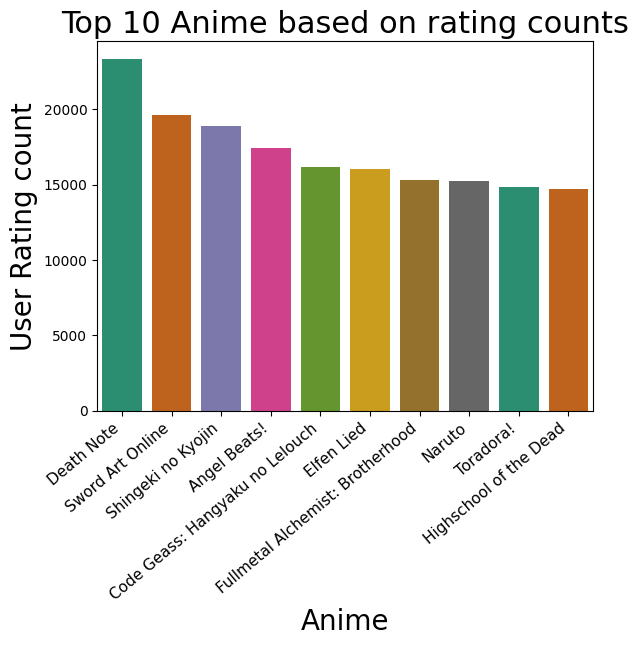

In [ ]:
# Creating a dataframe for rating counts
combine_anime_rating = anime_fulldata.dropna(axis = 0, subset = ['anime_title'])
anime_ratingCount = (combine_anime_rating.
     groupby(by = ['anime_title'])['user_rating'].
     count().
     reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['anime_title', 'user_rating']]
    )


top10_animerating=anime_ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="user_rating", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20)
ax.set_ylabel('User Rating count', fontsize = 20)

Death Note sweeps the war for rating count followed by SAO, SNK and code geass respectively.

In [ ]:
anime_fulldata = anime_fulldata.merge(anime_ratingCount, left_on = 'anime_title', right_on = 'anime_title', how = 'left')
anime_fulldata = anime_fulldata.rename(columns={'user_rating_x': 'user_rating', 'user_rating_y': 'totalratingcount'})

## Top 10 Anime based on Community size
#### I'm now sensing the top anime's based on their community size(membercount) . Let's see who tops the throne

In [ ]:
duplicate_anime=anime_fulldata.copy()
duplicate_anime.drop_duplicates(subset ="anime_title",
                     keep = 'first', inplace = True)

Text(0, 0.5, 'Community Size')

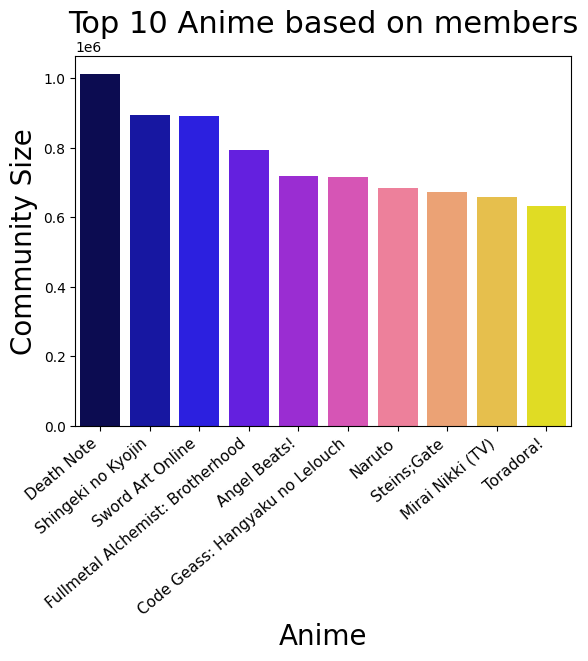

In [ ]:
top10_animemembers=duplicate_anime[['anime_title', 'members']].sort_values(by = 'members',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="members", data=top10_animemembers, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20)
ax.set_ylabel('Community Size', fontsize = 20)

Once again Death Note is victorious followed by SNK,SAO and FMAB respectively.

## Distribution of ratings
#### I'll be now sensing the distribution of ratings on both the datasets. I believe the rating from anime.csv is from review websites and user_rating in rating.csv is from user id's

Text(0.5, 1.0, 'Rating of users')

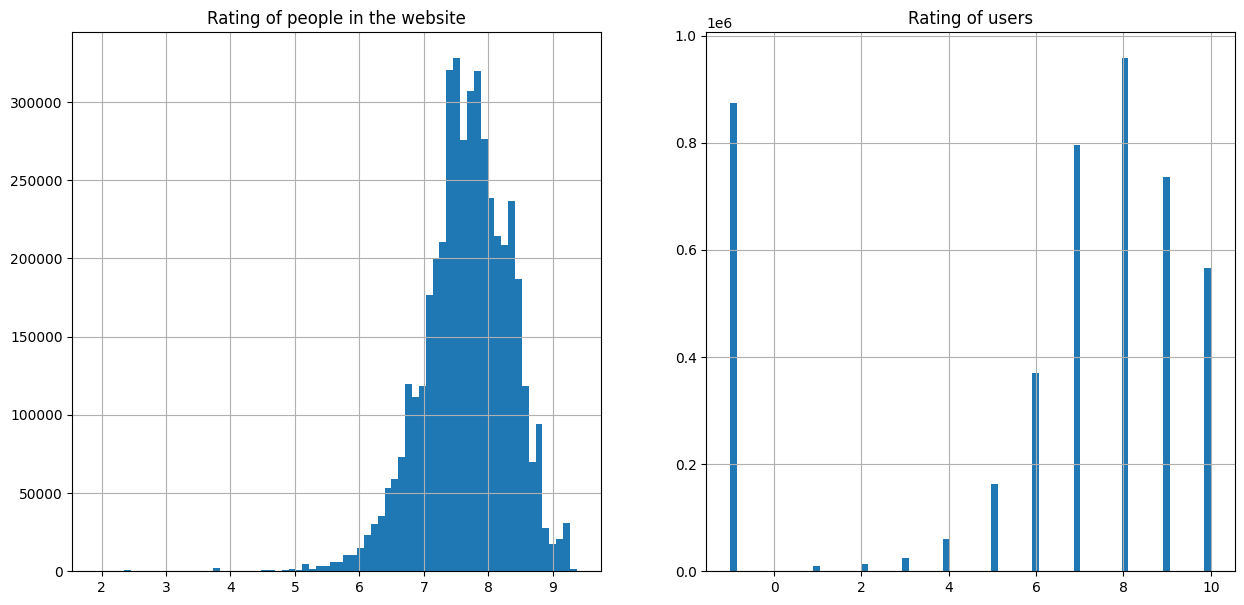

In [ ]:
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
anime_fulldata['rating'].hist(bins=70)
plt.title("Rating of people in the website")
plt.subplot(1,2,2)
anime_fulldata['user_rating'].hist(bins=70)
plt.title("Rating of users")

**Insights:**
* Most of the ratings are spread between 6-10
* The mode of the distribution is around 7.5-8.0
* Both the distribution are left skewed
* We have -1 rating as an outlier in rating of users which can be made into NaN

## Type of Anime
#### I'm now seeing from where does this powerful anime's are coming from

In [ ]:
import plotly.graph_objects as go
labels = anime_fulldata['type'].value_counts().index
values = anime_fulldata['type'].value_counts().values
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Medium of Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

**Insights:**
* 67.6% of the anime's were aired on TV followed by 13.5% through Movie
* 10.2% of anime's are streamed as OVA which is greater than ONA(1.18%)

## Genre cloud!

(-0.5, 799.5, 399.5, -0.5)

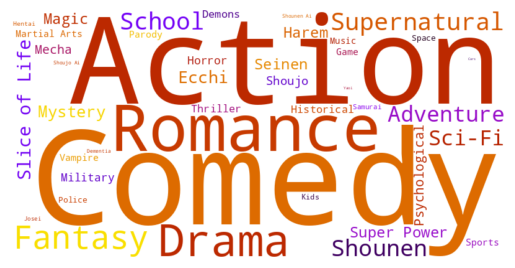

In [ ]:
nonull_anime=anime_fulldata.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

We can sense there are many Comedy genre anime's followd by action, romance,drama in our dataset

#Handling missing values

In [ ]:
print("Anime missing values :\n")
print(anime_df.isnull().sum().sort_values(ascending=False))
print("\n","*"*50,"\n\nRating missing values :\n")
print(rating_df.isnull().sum().sort_values(ascending=False))

Anime missing values :

rating      230
genre        62
type         25
anime_id      0
name          0
episodes      0
members       0
dtype: int64

 ************************************************** 

Rating missing values :

anime_id    1
rating      1
user_id     0
dtype: int64


P.S - It seems only the anime dataset has missing values.

In [ ]:
print(anime_df['type'].mode())
print(anime_df['genre'].mode())

0    TV
Name: type, dtype: object
0    Hentai
Name: genre, dtype: object


Most of the anime that are collected in this dataset belog to the `Hentai` and type is `TV`



In [ ]:
# deleting anime with 0 rating
anime_df=anime_df[~np.isnan(anime_df["rating"])]

In [ ]:
# filling mode value for genre and type
anime_df['genre'] = anime_df['genre'].fillna(
anime_df['genre'].dropna().mode().values[0])

anime_df['type'] = anime_df['type'].fillna(
anime_df['type'].dropna().mode().values[0])

<ipython-input-44-4e71e386f883>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-44-4e71e386f883>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#checking if all null values are filled
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

# Recommendation system

### Filling Nan values

In general the value `-1` suggests the user did not register a rating so we will fill with `Nan` values.

In [ ]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: np.nan if x==-1 else x)
rating_df.head(20)

,user_id,anime_id,rating
0,1,20.0,NaN
1,1,24.0,NaN
2,1,79.0,NaN
3,1,226.0,NaN
4,1,241.0,NaN
5,1,355.0,NaN
6,1,356.0,NaN
7,1,442.0,NaN
8,1,487.0,NaN
9,1,846.0,NaN


### Now we will engineer our Dataframe in the following steps:

1. We want to recomment anime series only so the the relevant `type` is `TV`
2. We make a new Dataframe combining both anime and rating on the `anime_id` column.
3. Leaving only `	user_id`, `name` and `rating` as the Df.
4. For computing purpose only we compute our Df based only on the first 7500 users.

In [ ]:
#step 1
anime_df = anime_df[anime_df['type']=='TV']

#step 2
rated_anime = rating_df.merge(anime_df, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])

#step 3
rated_anime =rated_anime[['user_id', 'name', 'rating']]

#step 4
rated_anime_7500= rated_anime[rated_anime.user_id <= 7500]
rated_anime_7500.head()

,user_id,name,rating
0,1,Naruto,7.81
1,3,Naruto,7.81
2,5,Naruto,7.81
3,6,Naruto,7.81
4,10,Naruto,7.81


### Pivot Table for similarity

We will create a pivot table of users as rows and tv show names as columns. The pivot table will help us will be analized for the calcuations of similarity.

In [ ]:
pivot = rated_anime_7500.pivot_table(index=['user_id'], columns=['name'], values='rating')
pivot.head()

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,...,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,6.49,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.11,NaN


### Now we will engineer our pivot table in the following steps:

1. Value normalization.
2. Filling `Nan` values as `0`.
3. Transposing the pivot for the next step.
4. Dropping columns with the values of `0` (unrated).
5. Using `scipy` package to convert to sparse matrix format for the similarity computation.


In [ ]:
# step 1
pivot_n = pivot.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

# step 2
pivot_n.fillna(0, inplace=True)

# step 3
pivot_n = pivot_n.T

# step 4
pivot_n = pivot_n.loc[:, (pivot_n != 0).any(axis=0)]

# step 5
piv_sparse = sp.sparse.csr_matrix(pivot_n.values)

# Cosine Similarity Model

![](https://media3.giphy.com/headers/CosineDotRip/dLeMRat9wmuZ.gif)

**formula:**
![](https://cdn-images-1.medium.com/max/579/1*5hJibEtQPavnbgRxg8w2Fg.gif)

Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction (more on [sciencedirect](https://www.sciencedirect.com/topics/computer-science/cosine-similarity)).

In [ ]:
#model based on anime similarity
anime_similarity = cosine_similarity(piv_sparse)

#Df of anime similarities
ani_sim_df = pd.DataFrame(anime_similarity, index = pivot_n.index, columns = pivot_n.index)

In [ ]:
def anime_recommendation(ani_name):
    """
    This function will return the top 5 shows with the highest cosine similarity value and show match percent

    example:
    >>>Input:

    anime_recommendation('Death Note')

    >>>Output:

    Recommended because you watched Death Note:

                    #1: Code Geass: Hangyaku no Lelouch, 57.35% match
                    #2: Code Geass: Hangyaku no Lelouch R2, 54.81% match
                    #3: Fullmetal Alchemist, 51.07% match
                    #4: Shingeki no Kyojin, 48.68% match
                    #5: Fullmetal Alchemist: Brotherhood, 45.99% match


    """

    number = 1
    print('Recommended because you watched {}:\n'.format(ani_name))
    for anime in ani_sim_df.sort_values(by = ani_name, ascending = False).index[1:6]:
        print(f'#{number}: {anime}, {round(ani_sim_df[anime][ani_name]*100,2)}% match')
        number +=1

In [ ]:
anime_recommendation('Shingeki no Kyojin')

Recommended because you watched Shingeki no Kyojin:

#1: No Game No Life, 53.8% match
#2: Angel Beats!, 49.61% match
#3: Death Note, 48.68% match
#4: Noragami, 47.0% match
#5: Psycho-Pass, 45.88% match
